In [1]:
# codes referenced from airbnb sentiment analysis performed by Michael Wynn, Nishant Singh, and Elias Kim
# found here: https://github.com/Michwynn/London-Airbnb-Analysis---2

In [2]:
# supress warnings
import warnings 
warnings.filterwarnings('ignore')

# data manipulation
import pandas as pd
import re # regex
import string

# machine learning
from sklearn.feature_extraction.text import TfidfVectorizer

# data visualisation
import matplotlib.pyplot as plt

# NLP
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # comment out if already downloaded
stop_words = set(stopwords.words('english'))
nltk.download('punkt')     # comment out if already downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Display all columns
pd.set_option('display.max_columns', None)

# unsupervised learning modules

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
!pip install gensim
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel

from pprint import pprint

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathanharper/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jonathanharper/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathanharper/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jonathanharper/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
df = pd.read_csv('df_reviews.csv', header = 1)
df = df.drop(['0'], axis = 1)

## sklearn LDA

In [4]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx+1}:")
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [5]:
count_vectorizer = TfidfVectorizer(
                        strip_accents='unicode',
                        ngram_range=(1, 2),
                        min_df=3,
                        max_features = 5000)

In [6]:
df = df[df['clean_tokens'].notna()]
df

,app_id,app_name,review_score,review_votes,num_words,clean_tokens,0.0,Neutral
0,107410,Arma 3,1,1,178,spend year army get to game spot training atmo...,0.88,Positive
1,107410,Arma 3,1,0,59,join exile sever find year old kid kid say m l...,-0.69,Negative
2,107410,Arma 3,1,0,9,game realize fps playable,0.00,Neutral
3,107410,Arma 3,1,0,174,game cause lose free time drop k machine run u...,0.56,Positive
4,107410,Arma 3,1,1,43,good game newbie use sit place watch sunset id...,0.64,Positive
...,...,...,...,...,...,...,...,...
610779,230410,Warframe,-1,0,40,excellent game digital extreme decide yeah qua...,0.86,Positive
610780,230410,Warframe,1,0,75,glast gambit quest disaster not bad play game ...,0.38,Positive
610781,230410,Warframe,1,0,19,harry connell love game play guy dezza derek g...,0.77,Positive
610782,230410,Warframe,1,0,53,warframe new accoutns old get ban violate term...,-0.84,Negative


In [7]:
all_topics = 14
neg_topics = 8
pos_topics = 12
neu_topics = 14

number_words = 10

In [8]:
%%time
bag_of_words = count_vectorizer.fit_transform(df['clean_tokens'])

# Create and fit the LDA model
lda = LDA(n_components=all_topics, random_state=42, n_jobs=-1, learning_method='online')
lda.fit(bag_of_words)

print_topics(lda, count_vectorizer, number_words)


Topic #1:
game play not good like great fun time amazing story

Topic #2:
buy not minecraft like minecraft game stop buy game play bad ball

Topic #3:
good good game game play game play game good favorite favorite game addict time

Topic #4:
ninja like masterpiece like game toby space ninja game like beat new update age

Topic #5:
boss ninjas kill space adventure awsome car to soccer space ninjas

Topic #6:
skeleton review wonderful gwent tear game great possibly write rip great gameplay

Topic #7:
life hour pay win valve win hour fun real goty minute ill

Topic #8:
grind need update repetitive dead run thing game forever thing flower

Topic #9:
nice amazing addictive nice game recommend word game highly game amazing highly recommend

Topic #10:
awesome love love game awesome game cry game awesome game game love dota far

Topic #11:
fun great great game friend game play friend fun game play fun play lot

Topic #12:
terraria ve ve play game ve music good play good game game wow

Topic 

## Gensim LSA

In [9]:
def clean_up(text, stem="None"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()

    useless_words = nltk.corpus.stopwords.words("english")

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    stem_clean = [word for word in text_stemmed if not word in useless_words]
    final_string = ' '.join(stem_clean)
    
    tokens = nltk.word_tokenize(final_string)

    return tokens

In [10]:
%%time
# df.drop('clean_tokens', axis=1, inplace=True)
df['clean_tokens_list'] = df['clean_tokens'].apply(clean_up, stem='Lem')
display(df.head(5))

,app_id,app_name,review_score,review_votes,num_words,clean_tokens,0.0,Neutral,clean_tokens_list
0,107410,Arma 3,1,1,178,spend year army get to game spot training atmo...,0.88,Positive,"[spend, year, army, get, game, spot, training,..."
1,107410,Arma 3,1,0,59,join exile sever find year old kid kid say m l...,-0.69,Negative,"[join, exile, sever, find, year, old, kid, kid..."
2,107410,Arma 3,1,0,9,game realize fps playable,0.00,Neutral,"[game, realize, fps, playable]"
3,107410,Arma 3,1,0,174,game cause lose free time drop k machine run u...,0.56,Positive,"[game, cause, lose, free, time, drop, k, machi..."
4,107410,Arma 3,1,1,43,good game newbie use sit place watch sunset id...,0.64,Positive,"[good, game, newbie, use, sit, place, watch, s..."


CPU times: user 1min 40s, sys: 7.24 s, total: 1min 47s
Wall time: 1min 48s


In [11]:
#Positive sentiment dataframe
positive_df = df[df['Neutral']=='Positive']
#Negative sentiment dataframe
negative_df = df[df['Neutral']=='Negative']
#Neutral sentiment dataframe
neutral_df = df[df['Neutral']=='Neutral']

In [12]:
def prepare_corpus(doc_clean,sentiment):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(df['clean_tokens_list'])
    dictionary.filter_extremes(no_below=3)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    if sentiment == 'Positive':
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in positive_df['clean_tokens_list']]
    elif sentiment == 'Negative':
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in negative_df['clean_tokens_list']]
    elif sentiment == 'Neutral':
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in neutral_df['clean_tokens_list']]
    elif sentiment == 'All':
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in df['clean_tokens_list']]
    return dictionary,doc_term_matrix

In [13]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words,sentiment):
    
    chunksize = 2000
    
    dictionary, doc_term_matrix = prepare_corpus(doc_clean,sentiment)
    # generate LSA model
    model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary, 
                        chunksize = chunksize)  # train model
    print(model.print_topics(num_topics=number_of_topics, num_words=words))
    
    return model

In [14]:
from gensim.models import KeyedVectors

# Load pre-trained GloVe word embedding model
glove_model_path = 'glove.6B.300d.txt'  # replace with the path to your GloVe model file
glove_model = KeyedVectors.load_word2vec_format(glove_model_path, binary=False)

In [15]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=2):
    
    chunksize = 2000

    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary, 
                         chunksize = chunksize, random_seed = 42)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, 
                                        coherence='c_v', keyed_vectors=glove_model)
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Num Topics = 2  has Coherence Value of 0.6007
Num Topics = 4  has Coherence Value of 0.6054
Num Topics = 6  has Coherence Value of 0.6017
Num Topics = 8  has Coherence Value of 0.6171
Num Topics = 10  has Coherence Value of 0.6105
Num Topics = 12  has Coherence Value of 0.6022
Num Topics = 14  has Coherence Value of 0.6162
Num Topics = 16  has Coherence Value of 0.6008
Num Topics = 18  has Coherence Value of 0.6124


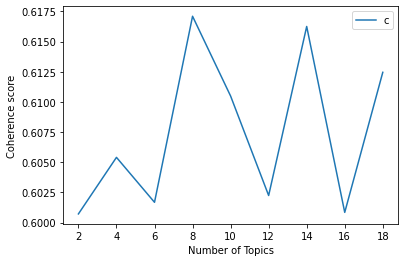

In [16]:
warnings.filterwarnings('ignore')

def plot_graph(doc_clean,start, stop, step,sentiment):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean,sentiment)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step = 2, 20, 2
plot_graph(df['clean_tokens_list'], start, stop, step, 'Negative')

In [17]:
%%time
# Positive sentiment model
pos_model=create_gensim_lsa_model(positive_df['clean_tokens_list'],pos_topics,number_words,'Positive')
# Negative sentiment model
neg_model=create_gensim_lsa_model(negative_df['clean_tokens_list'],neg_topics,number_words,'Negative')
# Neutral sentiment model
neu_model=create_gensim_lsa_model(neutral_df['clean_tokens_list'],neu_topics,number_words,'Neutral')
# All sentiments model
all_model=create_gensim_lsa_model(df['clean_tokens_list'],all_topics,number_words,'All')

[(0, '0.640*"play" + 0.347*"good" + 0.246*"like" + 0.223*"fun" + 0.186*"great" + 0.163*"time" + 0.122*"friend" + 0.120*"buy" + 0.108*"hour" + 0.099*"story"'), (1, '0.744*"good" + -0.596*"play" + 0.162*"like" + 0.102*"great" + 0.087*"story" + -0.077*"friend" + 0.057*"graphic" + -0.053*"fun" + 0.051*"gameplay" + 0.047*"buy"'), (2, '-0.531*"good" + 0.528*"like" + -0.388*"play" + 0.320*"great" + 0.228*"fun" + 0.081*"buy" + 0.081*"feel" + 0.073*"new" + 0.071*"love" + 0.071*"lot"'), (3, '-0.667*"great" + 0.650*"like" + -0.270*"fun" + 0.095*"play" + -0.095*"story" + -0.072*"friend" + 0.061*"feel" + -0.060*"gameplay" + -0.045*"graphic" + -0.044*"time"'), (4, '-0.814*"fun" + 0.457*"great" + -0.164*"friend" + 0.150*"play" + 0.134*"story" + 0.113*"like" + -0.074*"lot" + 0.073*"love" + -0.070*"good" + 0.051*"character"'), (5, '-0.382*"like" + -0.379*"great" + 0.342*"buy" + 0.329*"time" + -0.212*"fun" + 0.207*"love" + 0.167*"amazing" + 0.164*"hour" + -0.163*"play" + -0.151*"good"'), (6, '-0.552*"st

In [36]:
!pip install wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def visual_topics(model, rows):
    cols = [color for name, color in mcolors.CSS4_COLORS.items()]  
    
    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i+10],
                      prefer_horizontal=1.0)

    topics = model.show_topics(formatted=False)

    fig, axes = plt.subplots(int(rows/2), 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        cloud.fit_words(dict(model.show_topic(i, 200)))
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

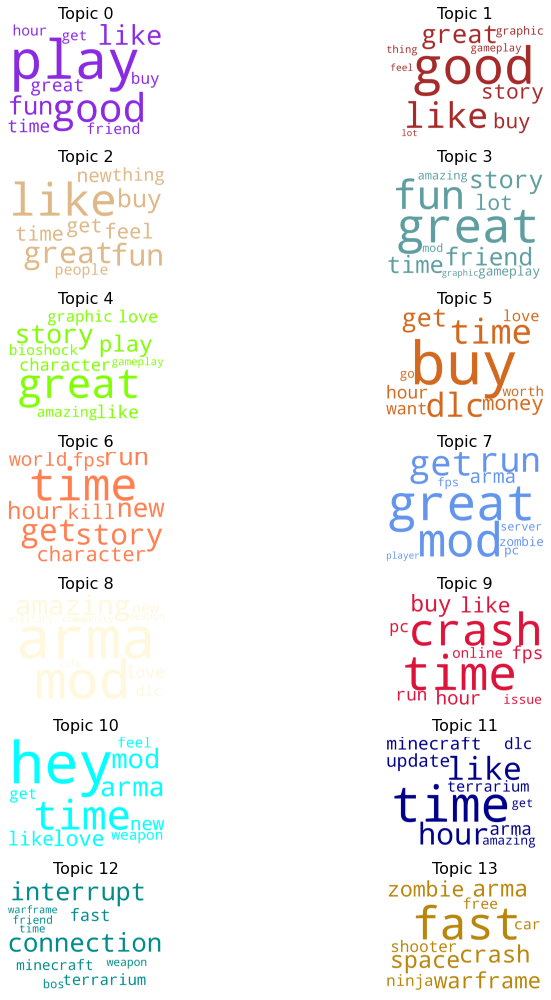

In [19]:
visual_topics(all_model, all_topics)

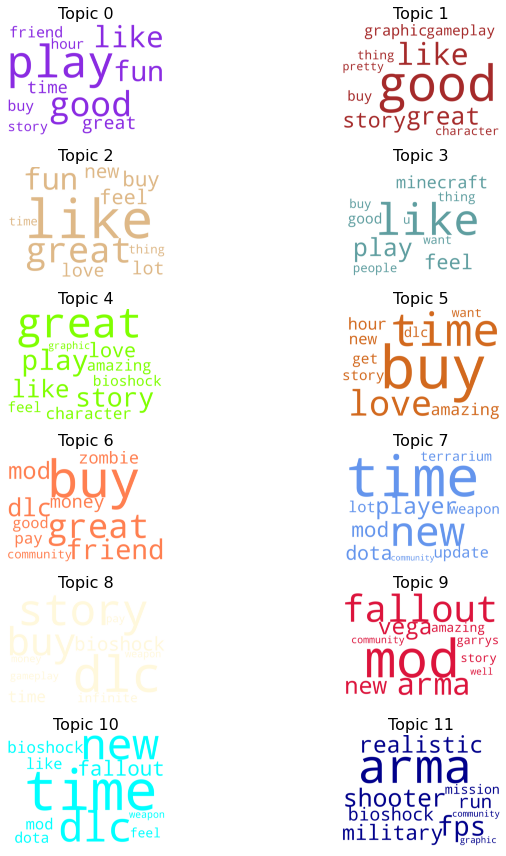

In [20]:
visual_topics(pos_model, pos_topics)

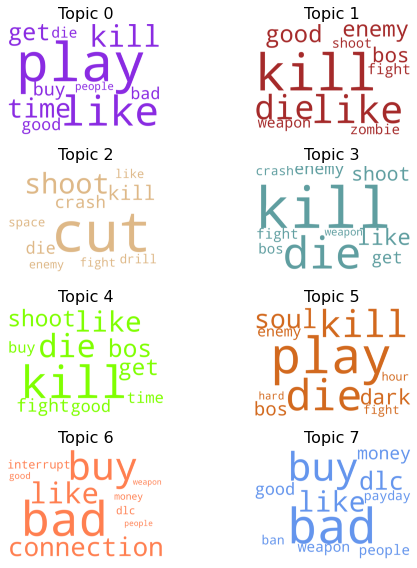

In [21]:
visual_topics(neg_model, neg_topics)

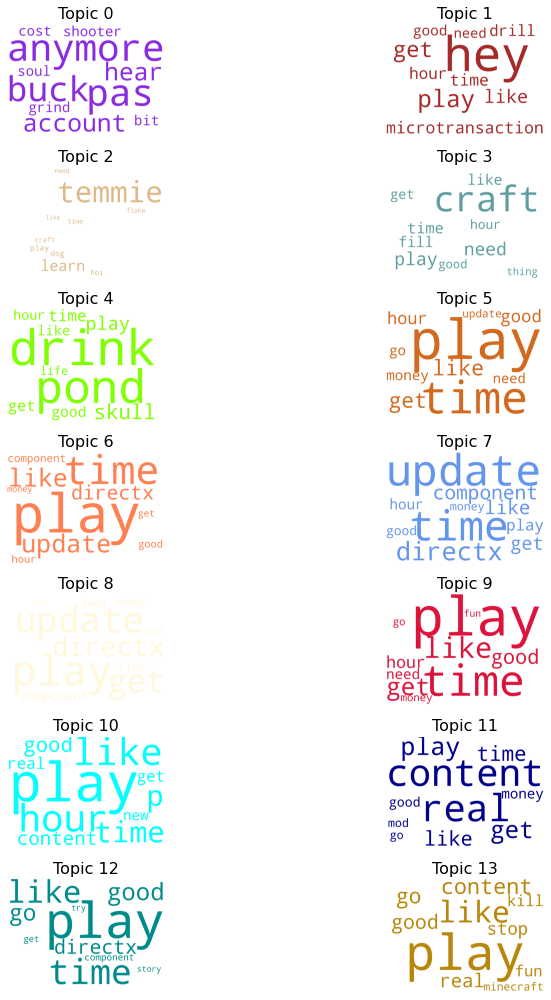

In [22]:
visual_topics(neu_model, neu_topics)

## Gensim LDA

In [23]:
def lda_gen(clean_data, num_topics):
    # Making dictionary
    dictionary = corpora.Dictionary(clean_data)
    # Remove extremes
    dictionary.filter_extremes(no_below=3)
    # Making corpus
    corpus = [dictionary.doc2bow(text) for text in clean_data]
    # Making model
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None

    temp = dictionary[0]
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )
  
    return model

In [24]:
def print_topics(sentiment):
    if sentiment == 'Positive':
        dictionary = corpora.Dictionary(positive_df['clean_tokens_list'])
        corpus = [dictionary.doc2bow(text) for text in positive_df['clean_tokens_list']]
        top_topics = lda_gen(positive_df['clean_tokens_list'], pos_topics).top_topics(corpus)
    elif sentiment == 'Negative':
        dictionary = corpora.Dictionary(negative_df['clean_tokens_list'])
        corpus = [dictionary.doc2bow(text) for text in negative_df['clean_tokens_list']]
        top_topics = lda_gen(negative_df['clean_tokens_list'], neg_topics).top_topics(corpus)
    elif sentiment == 'Neutral':
        dictionary = corpora.Dictionary(neutral_df['clean_tokens_list'])
        corpus = [dictionary.doc2bow(text) for text in neutral_df['clean_tokens_list']]
        top_topics = lda_gen(neutral_df['clean_tokens_list'], neu_topics).top_topics(corpus)
    elif sentiment == 'All':
        dictionary = corpora.Dictionary(df['clean_tokens_list'])
        corpus = [dictionary.doc2bow(text) for text in df['clean_tokens_list']]
        top_topics = lda_gen(df['clean_tokens_list'], all_topics).top_topics(corpus)
    pprint(top_topics)

In [25]:
print("Printing positive topcis")
print("==========================")
print_topics('Positive')
print("Printing negative topcis")
print("==========================")
print_topics('Negative')
print("Printing neutral topcis")
print("==========================")
print_topics('Neutral')
print("Printing all topics")
print("==========================")
print_topics('All')

Printing positive topcis
[([(0.21242574, 'play'),
   (0.1395095, 'good'),
   (0.08449027, 'like'),
   (0.063687906, 'time'),
   (0.037814107, 'hour'),
   (0.036795374, 'get'),
   (0.02344427, 'need'),
   (0.022840373, 'look'),
   (0.022558687, 'pretty'),
   (0.02250471, 'think'),
   (0.018836323, 'spend'),
   (0.016129283, 'long'),
   (0.015074096, 'cool'),
   (0.013470475, 'little'),
   (0.013432608, 'stuff'),
   (0.011181381, 'far'),
   (0.011176169, 'day'),
   (0.010759574, 'steam'),
   (0.010050976, 'life'),
   (0.009928378, 'u')],
  -8.745535706544723),
 ([(0.05312236, 'love'),
   (0.036697134, 'thing'),
   (0.03594215, 'want'),
   (0.028267024, 'try'),
   (0.023875829, 'way'),
   (0.021106085, 'undertale'),
   (0.020915443, 'people'),
   (0.02055757, 'start'),
   (0.01967389, 'come'),
   (0.019444177, 'find'),
   (0.019424014, 'know'),
   (0.019029867, 'go'),
   (0.013408498, 'review'),
   (0.013212365, 'bad'),
   (0.01131905, 'say'),
   (0.011109731, 'music'),
   (0.010868178, '

[([(0.1736999, 'hour'),
   (0.087575905, 'try'),
   (0.064859204, 'spend'),
   (0.06184062, 'wait'),
   (0.050267383, 'find'),
   (0.044330094, 'epic'),
   (0.032880362, 'addict'),
   (0.031495832, 'player'),
   (0.01890472, 'minute'),
   (0.018095562, 'mean'),
   (0.01689229, 'simple'),
   (0.01599408, 'screen'),
   (0.015172565, 'single'),
   (0.014917619, 'later'),
   (0.013544824, 'eye'),
   (0.012537609, 'base'),
   (0.012469624, 'team'),
   (0.011336268, 'h'),
   (0.011330041, 'card'),
   (0.010895475, 'set')],
  -14.742687227159118),
 ([(0.08304556, 'time'),
   (0.077529445, 'play'),
   (0.044820767, 'good'),
   (0.034946397, 'feel'),
   (0.022532636, 'fun'),
   (0.019104859, 'weapon'),
   (0.018993245, 'make'),
   (0.018005826, 'graphic'),
   (0.01788131, 'want'),
   (0.014612048, 'experience'),
   (0.013896305, 'little'),
   (0.013309957, 'farming'),
   (0.013043775, 'bad'),
   (0.0128483735, 'kill'),
   (0.012747251, 'well'),
   (0.012494591, 'bit'),
   (0.0124333715, 'favour

In [26]:
!pip install pyLDAvis
import pickle
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

def lda_vis(model,clean_data):
    if clean_data =='Positive':
        clean_data = positive_df['clean_tokens_list']
        dictionary = corpora.Dictionary(clean_data)
        # Remove extremes
        dictionary.filter_extremes(no_below=3)
        # Making corpus
        corpus = [dictionary.doc2bow(text) for text in clean_data]
        lda_visualization = gensimvis.prepare(model,corpus,dictionary, sort_topics=False)
        pyLDAvis.save_html(lda_visualization, 'LDA visualizations_positive.html')
    elif clean_data =='Negative':
        clean_data = negative_df['clean_tokens_list']
        dictionary = corpora.Dictionary(clean_data)
        # Remove extremes
        dictionary.filter_extremes(no_below=3)
        # Making corpus
        corpus = [dictionary.doc2bow(text) for text in clean_data]
        lda_visualization = gensimvis.prepare(model,corpus,dictionary, sort_topics=False)
        pyLDAvis.save_html(lda_visualization, 'LDA visualizations_negative.html')
    elif clean_data =='Neutral':
        clean_data = neutral_df['clean_tokens_list']
        dictionary = corpora.Dictionary(clean_data)
        # Remove extremes
        dictionary.filter_extremes(no_below=3)
        # Making corpus
        corpus = [dictionary.doc2bow(text) for text in clean_data]
        lda_visualization = gensimvis.prepare(model,corpus,dictionary, sort_topics=False)
        pyLDAvis.save_html(lda_visualization, 'LDA visualizations_neutral.html')
    elif clean_data =='All':
        clean_data = df['clean_tokens_list']
        dictionary = corpora.Dictionary(clean_data)
        # Remove extremes
        dictionary.filter_extremes(no_below=3)
        # Making corpus
        corpus = [dictionary.doc2bow(text) for text in clean_data]
        lda_visualization = gensimvis.prepare(model,corpus,dictionary, sort_topics=False)
        pyLDAvis.save_html(lda_visualization, 'LDA visualizations_all.html')

In [27]:
lda_vis(lda_gen(positive_df['clean_tokens_list'], pos_topics),'Positive')
lda_vis(lda_gen(negative_df['clean_tokens_list'], neg_topics),'Negative')
lda_vis(lda_gen(neutral_df['clean_tokens_list'], neu_topics),'Neutral')
lda_vis(lda_gen(df['clean_tokens_list'], all_topics), 'All')

In [30]:
## sensitivity testing

warnings.filterwarnings('ignore')

# Positive sentiment model
neg_model_2 = create_gensim_lsa_model(negative_df['clean_tokens_list'],2,number_words,'Negative')
# Negative sentiment model
neg_model_16 = create_gensim_lsa_model(negative_df['clean_tokens_list'],16,number_words,'Negative')
# Neutral sentiment model
neg_model_8 = create_gensim_lsa_model(negative_df['clean_tokens_list'],8,number_words,'Negative')
# All sentiments model
neg_model_14 = create_gensim_lsa_model(negative_df['clean_tokens_list'],14,number_words,'Negative')

[(0, '0.456*"fast" + 0.336*"play" + 0.269*"kill" + 0.215*"like" + 0.194*"time" + 0.166*"get" + 0.163*"buy" + 0.154*"good" + 0.134*"bad" + 0.122*"crash"'), (1, '-0.998*"cut" + 0.041*"fast" + -0.016*"shoot" + 0.014*"play" + 0.010*"kill" + 0.009*"crash" + 0.009*"like" + 0.008*"time" + 0.008*"buy" + 0.006*"good"')]
[(0, '0.459*"play" + 0.253*"kill" + 0.250*"like" + 0.232*"time" + 0.204*"get" + 0.178*"buy" + 0.176*"good" + 0.171*"bad" + 0.129*"die" + 0.125*"people"'), (1, '-0.981*"crash" + 0.105*"kill" + -0.099*"crashcrash" + 0.048*"like" + 0.035*"die" + 0.028*"good" + -0.027*"fix" + 0.021*"enemy" + -0.020*"work" + 0.018*"weapon"'), (2, '0.830*"cut" + -0.411*"play" + 0.283*"kill" + 0.086*"like" + 0.082*"shoot" + 0.080*"get" + 0.079*"die" + 0.049*"crash" + -0.048*"bad" + 0.042*"enemy"'), (3, '-0.606*"play" + -0.557*"cut" + 0.434*"kill" + 0.138*"like" + 0.124*"get" + 0.118*"die" + 0.088*"shoot" + 0.070*"crash" + -0.065*"bad" + 0.062*"enemy"'), (4, '-0.598*"kill" + -0.433*"play" + 0.287*"like"

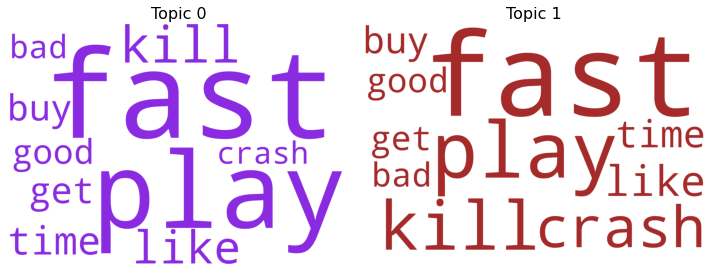

In [37]:
visual_topics(neg_model_2, 2)

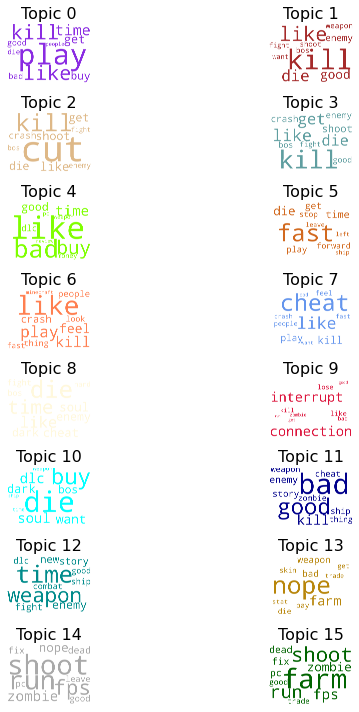

In [38]:
visual_topics(neg_model_16, 16)

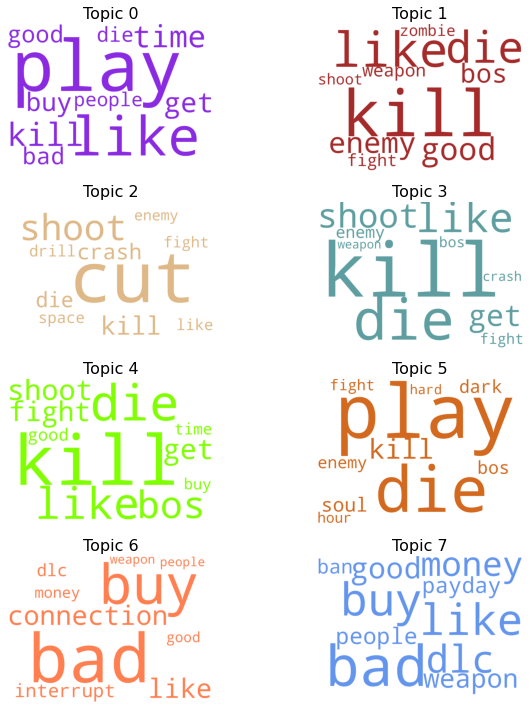

In [39]:
visual_topics(neg_model_8, 8)

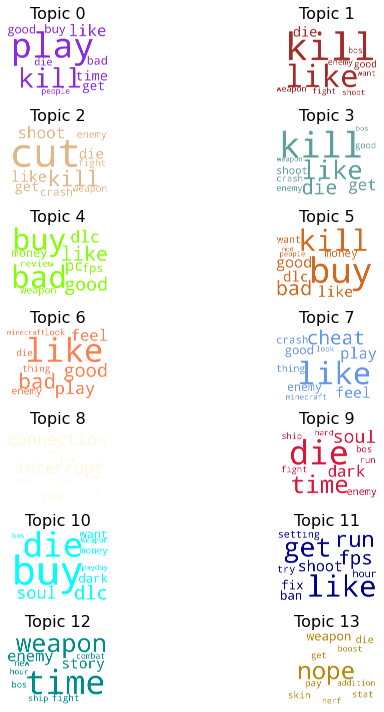

In [40]:
visual_topics(neg_model_14, 14)